In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from openpiv import tools, pyprocess, validation, filters,preprocess
import pims
import matplotlib 

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 14

In [20]:

def manual_piv(thresh,maxValue,path_to_frame1,path_to_frame2,winsize,searchsize,overlap,path_to_save,t):
    a = cv2.imread(path_to_frame1,cv2.IMREAD_GRAYSCALE)
    b = cv2.imread(path_to_frame2,cv2.IMREAD_GRAYSCALE)

    th, a = cv2.threshold(a, thresh, maxValue, cv2.THRESH_BINARY)
    th2, b = cv2.threshold(b, thresh, maxValue, cv2.THRESH_BINARY)
    

    a,c=preprocess.dynamic_masking(a,'edges',0.36)
    b,c2=preprocess.dynamic_masking(b,'edges',0.36)

    u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        a,
        b,
        window_size=winsize,
        overlap=overlap,
        search_area_size=searchsize,
        sig2noise_method='peak2peak',
    )
    x, y = pyprocess.get_coordinates(
        image_size=a.shape,
        search_area_size=searchsize,
        overlap=overlap,
    )
    flags = validation.sig2noise_val(u=u0,v=v0,s2n=sig2noise, threshold = 0.9)
    u0, v0 = filters.replace_outliers( u0, v0, flags, method='localmean', max_iter=4, kernel_size=4)
    
    flags = flags[2]
    invalid=flags >0
    valid = ~invalid


    # xs_asym, ys_asym, dxs_asym, dys_asym = vel_field_asymmetric_wins(
    #     a, b, half_int_win_size, half_search_win_size
    # )
    # norm_drs_asym = np.sqrt(dxs_asym ** 2 + dys_asym ** 2)
    
    

    fig, axs = plt.subplots(figsize=(8,8))
    norm =np.sqrt(u0[valid]**2 + v0[valid]**2)
    # norm2 = np.sqrt((u0[valid]/norm[valid])**2+(v0[valid]/norm[valid])**2)

    cm=axs.quiver(x[valid],y[valid],u0[valid]/norm,v0[valid]/norm,norm,clim=[0.,1.],cmap="plasma",angles="xy",scale=18,width=0.008,pivot='tail')
    axs.imshow(a, cmap=plt.cm.gray,alpha=0.6)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_title(f'frame {t}')
    # axs.set_aspect("equal")
    fig.colorbar(cm,label='velocity')
    # plt.savefig(path_to_save,dpi=200)
    plt.close()

    return [x[valid],y[valid],u0[valid],v0[valid],norm]

In [21]:
def path_spitter(t):
    return f'data/new-videos/video2/original_frames/frame_{t:03d}.tif'

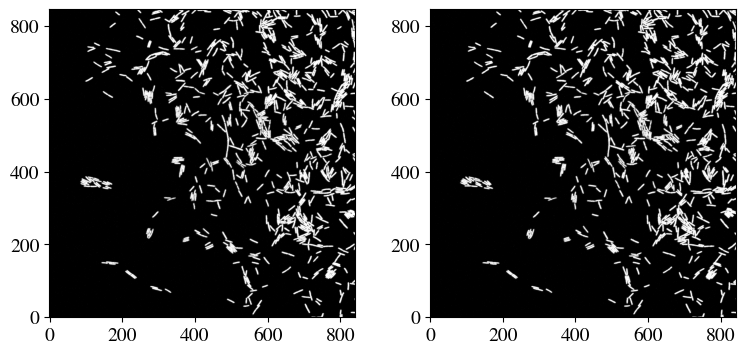

In [25]:
a = cv2.imread(path_spitter(0),cv2.IMREAD_GRAYSCALE)
b = cv2.imread(path_spitter(1),cv2.IMREAD_GRAYSCALE)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a, cmap=plt.cm.gray,origin='lower')
axs[1].imshow(b, cmap=plt.cm.gray,origin='lower')
plt.show()

In [22]:
thresh =80
maxValue=90
winsize=16
search=int(2*winsize)
overlap=8
count=0



for t in range(199):
    this = path_spitter(t)
    n = path_spitter(t+1)
    path_to_save = f'/media/janne/Transcend/bacteria/apoptotic_cells/frames/piv_images/frame_{t:03d}.tif'
    
    a=manual_piv(thresh,maxValue,this,n,winsize,search,overlap,path_to_save,t)

    np.savetxt(f'/media/janne/Transcend/bacteria/apoptotic_cells/frames/piv_images/piv_data/data_frame_{t:03d}.dat',np.transpose(a),header='x y u v norm', fmt='%.6f')

In [ ]:
all_of_them = []
for i in range(199):
    path = f'/media/janne/Transcend/bacteria/apoptotic_cells/frames/piv_images/piv_data/data_frame_{i:03d}.dat'
    data = np.loadtxt(path)
    all_of_them.append(data)

processed_arrays = []
max_lines = max(arr.shape[0] for arr in all_of_them)
for arr in all_of_them:
    if arr.shape[0] < max_lines:
        # Calculate the number of rows to append
        rows_to_add = max_lines - arr.shape[0]
        # Create a zero array with the correct shape
        zero_rows = np.zeros((rows_to_add, arr.shape[1]), dtype=arr.dtype)
        # Concatenate the original array with zero rows
        processed_arrays.append(np.concatenate((arr, zero_rows), axis=0))
    else:
        processed_arrays.append(arr)

all_frames = np.array(processed_arrays)

average_over_all = np.average(all_frames,axis=0)

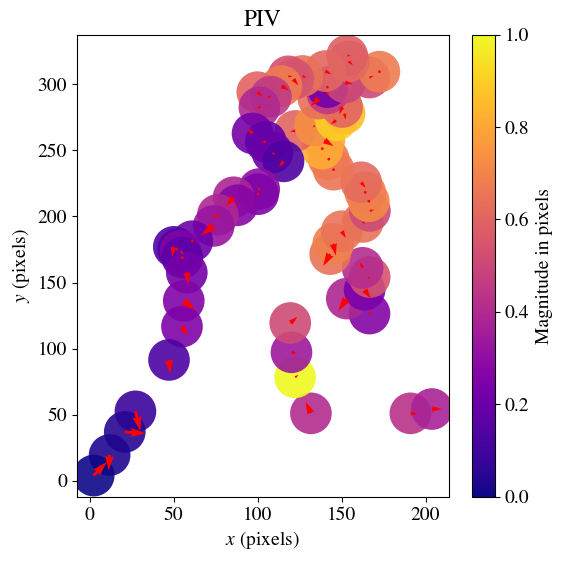

<Figure size 640x480 with 0 Axes>

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
norm =average_over_all[:,4]
fig1 = plt.figure()
# vx,vy = np.meshgrid(average_over_all[:,0],average_over_all[:,1])
ax.scatter(average_over_all[:,0],average_over_all[:,1],c=norm,cmap='plasma',s=900, alpha=0.9,edgecolor='none', marker='o')

cm = ax.quiver(average_over_all[:,0],average_over_all[:,1],average_over_all[:,2]/norm,average_over_all[:,3]/norm,cmap="plasma",angles="xy",scale=14,width=0.008,pivot='tail',color='red')
ax.set_xlabel(r'$x$ (pixels)')
ax.set_ylabel(r'$y$ (pixels)')
ax.set_title('PIV')
fig.colorbar(cm,cmap='plasma',label='Magnitude in pixels')
# cm1 = ax[1].imshow(np.average(speed_heatmaps,axis=0),cmap='plasma',interpolation='gaussian',origin='lower')

# fig1.colorbar(cm1,cmap='viridis',label=r'magnitude in $\mu m/s$')
# ax[1].set_xlabel(r'cells (8 x 8) $\mu m$')
# ax[1].set_title('tracked trajectories')
plt.show()

In [62]:
a.shape

(10816, 6)

In [68]:
b = np.zeros((10816, 6))
c = 0
for i in range(199):
    b = b + np.loadtxt(f'data/new-videos/video2/original_frames/vec_piv_FFT_{i:03d}_med_thrhld_repl.vec')
    c+=1
b = b/c

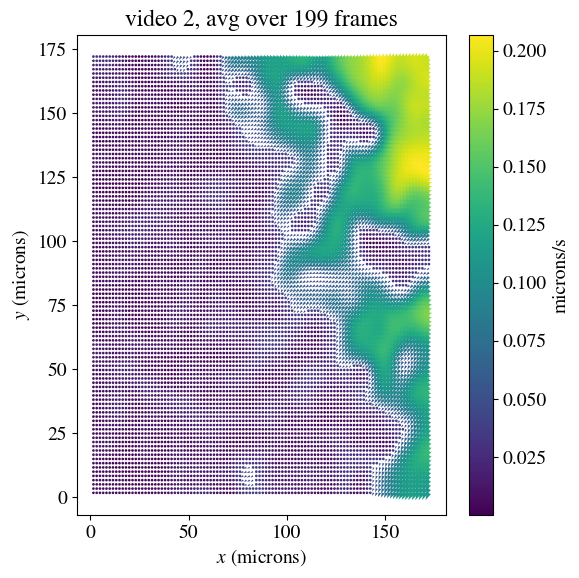

In [76]:
fig, ax = plt.subplots(figsize=(6,6))
a=b


m = np.sqrt(a[:,2]**2 + a[:,3]**2)

cm = ax.quiver(a[:,0][::-1],a[:,1][::-1],a[:,2],a[:,3],m,cmap="viridis",scale=5,width=0.008,pivot='tail')
ax.set_xlabel(r'$x$ (microns)')
ax.set_ylabel(r'$y$ (microns)')
ax.set_title('video 2, avg over 199 frames')
fig.colorbar(cm,cmap='viridis',label='microns/s')
# cm1 = ax[1].imshow(np.average(speed_heatmaps,axis=0),cmap='plasma',interpolation='gaussian',origin='lower')

# fig1.colorbar(cm1,cmap='viridis',label=r'magnitude in $\mu m/s$')
# ax[1].set_xlabel(r'cells (8 x 8) $\mu m$')
# ax[1].set_title('tracked trajectories')
plt.tight_layout()
plt.savefig('data/new-videos/video2/piv_199_avgframes.png',dpi=150,bbox_inches='tight')
plt.show()